In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import nltk
import pickle


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from gensim.utils import tokenize
from gensim.models import Phrases, Word2Vec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Dropout, BatchNormalization, LSTM, SpatialDropout1D, GRU, Bidirectional, Conv1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam


In [2]:
#download necessary packages
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\gangu\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
path_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_data.csv'
path_labels = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\train_results.csv'
path_test_data = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\DATA\\test_data.csv'

In [4]:
data_df = pd.read_csv(path_data)
label_df = pd.read_csv(path_labels)
test_df = pd.read_csv(path_test_data)

In [5]:
df = pd.merge(data_df, label_df, on='id')

In [6]:
df

,id,text,target
0,0,Anyway Im getting of for a while,positive
1,1,"My red, Apache isn't feelin too well this morn...",negative
2,2,@danyelljoy you should be its great. friday w...,positive
3,3,its 11:30pm and i dont wanna sleep; so i debat...,positive
4,4,Why does twitter eat my DM's? Not happy,negative
...,...,...,...
1040318,1040318,getting ready 2 watch mental,positive
1040319,1040319,Wristcutters and Half Nelson are on Sundance F...,negative
1040320,1040320,@t_isfortammy Going out in Northbridge makes m...,negative
1040321,1040321,@iModel_ lol.... Gorgeous...lol! U look sooo m...,positive


## Pre-Process Train

#### Helper functions

In [7]:
#word2vec train and fit function
def create_embedding(df):
    sentence_list = [row for row in feature_df['text']]
    w2v = Word2Vec(sample=3e-5, min_count=1)
    w2v.build_vocab(corpus_iterable=sentence_list)
    w2v.train(corpus_iterable=sentence_list, total_examples=w2v.corpus_count, epochs=100, report_delay=1)
    key_index = w2v.wv.key_to_index
    # MAKE A DICT
    word_dict = {word:w2v.wv[word] for word in key_index}
    
    embedding_weights = w2v.wv.vectors
    #add zeros vector to align indices of keras and gensim tokenizer
    row_zero = np.zeros((100))
    embedding_weights = np.insert(embedding_weights, 0, row_zero, axis=0)
    return word_dict, embedding_weights

In [7]:
def to_sequences(train_df, test_df):

    #list of input sentences
    X = train_df['text'].values

    #array of 0,1 and 2 labels
    Y = train_df['target'].to_numpy()
    input_tokenizer = Tokenizer()
    input_tokenizer.fit_on_texts(X)
    encoded_X = input_tokenizer.texts_to_sequences(X)
    
    # right pad for equal length 
    X_train = pad_sequences(encoded_X, maxlen=50, padding='post')
    
    #generate train-val set
    x_train, x_val, y_train, y_val = train_test_split(X_train, Y, stratify=Y, test_size=0.2, random_state=40)
    
    #test sequences
    X_test = test_df['text'].values
    x_test_sequences = input_tokenizer.texts_to_sequences(X_test)
    x_test = pad_sequences(x_test_sequences, maxlen=50, padding='post')
    return x_train, x_val, x_test, y_train, y_val

In [9]:
class PreProc():
    def __init__(self):
        pass
        
    def remove_more_stop_words(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: self.word_counts[word] >50)
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #return low frequency words + words that don't appear in train
    def remove_more_stop_words_test(self,words_arr):
        if (len(words_arr) > 0):
            remove = np.vectorize(lambda word: False if not word in self.word_counts else (True if self.word_counts[word] >50 else False))
            return words_arr[remove(words_arr)]
        else:
            return ['empty']

    #find the correct wordnet tag for nltk pos_tag equivalent  
    def get_wordnet_pos(self,treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    #lemmatize 
    def lemmatize(self,word_list):
        pos_tag = nltk.pos_tag(list(word_list))
        words = [self.lemmatizer.lemmatize(i[0], self.get_wordnet_pos(i[1])) for i in pos_tag]
        return words    
        
    def preproc(self,df, is_test=False):
    
        feature_df = df.copy()
        #convert lower case
        feature_df['text'] = feature_df['text'].str.lower()
        #remove URLS
        feature_df['text'] = feature_df['text'].str.replace(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])', '', regex=True)
        #remove mentions
        feature_df['text'] = feature_df['text'].str.replace(r'@([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove hashtags
        feature_df['text'] = feature_df['text'].str.replace(r'#([a-zA-Z0-9_]{1,50})', '', regex=True)
        #remove punctuations
        feature_df['text'] = feature_df['text'].str.replace(r'[^\w\s]', '', regex=True)
        #tokenize
        feature_df['text'] = feature_df['text'].apply(lambda x : np.asarray(list(tokenize(x))))

        if not is_test:
            #encode target labels 
            label_encoder = LabelEncoder()
            label_encoder.fit(feature_df['target'])
            feature_df['target'] = label_encoder.transform(feature_df['target'])
            #check word counts
            self.word_counts = feature_df.explode('text')['text'].value_counts().to_dict()
            #remove low frequency words
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words)

        elif is_test:
            feature_df['text'] = feature_df['text'].apply(self.remove_more_stop_words_test)

        #lemmatize
        self.lemmatizer = WordNetLemmatizer()
        feature_df['text'] = feature_df['text'].apply(self.lemmatize)

        if not is_test:
            #vocab
            vocabulary = feature_df.explode('text')['text'].value_counts().to_dict()
            #vocab length
            vocab_length = len(vocabulary)
            return feature_df, self.word_counts, vocabulary, vocab_length

        elif is_test:
            return feature_df
            
    

## Pre-Process data and save dataframe

In [10]:
preprocess = PreProc()
feature_df, word_counts, vocabulary, vocab_length = preprocess.preproc(df, is_test=False)
feature_df_test = preprocess.preproc(test_df, is_test=True)

In [2]:
path_df_NN_train = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_NN.pkl'
path_df_NN_test = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Dataframe\\lemmatized_feature_df_test_NN.pkl'


In [ ]:
#feature_df.to_pickle(path_df_NN_train)
#feature_df_test.to_pickle(path_df_NN_test)

In [3]:
feature_df = pd.read_pickle(path_df_NN_train)
feature_df_test = pd.read_pickle(path_df_NN_test)

#### Load data frame if saved

In [12]:
#Uncomment and load dataframe if already pre-processed and saved
#feature_df = pd.read_pickle(path_df_NN_train)
#feature_df_test = pd.read_pickle(path_df_NN_test)

## Create Word2Vec Embedding

In [13]:
word_dict, embedding_weights = create_embedding(feature_df)

In [4]:
# using skipgra eembeddings from lstm
path_word_dict = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\word_dict.pkl'
path_embedding_weights = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Models\\Word2Vec_weights.pkl'

In [5]:
word_dict = pickle.load( open(path_word_dict, 'rb'))
embedding_weights =pickle.load(open(path_embedding_weights, 'rb'))

## Create train-val and test sets

In [8]:
x_train, x_val, x_test, y_train, y_val = to_sequences(feature_df, feature_df_test)

## Model Dense NN

In [9]:
def create_model():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_weights.shape[0], output_dim=embedding_weights.shape[1], weights=[embedding_weights], trainable=False, input_length=50))
    model.add(Flatten())
    model.add(Dense(64, activation="relu", name="layer1"))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation="relu", name="layer3"))
    model.add(Dense(3, activation="softmax"))
    return model

nn_model = create_model()

In [10]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           905600    
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 layer1 (Dense)              (None, 64)                320064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 layer3 (Dense)              (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1,227,843
Trainable params: 322,243
Non-tr

In [11]:
def train(x, y, model, optimizer, loss, metrics, batch_size, epochs, validation_data):
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(
        x,
        y,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data,
        shuffle=True,
    )
    return history

In [12]:
model_metrics = train(x_train, y_train, model=nn_model,optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], batch_size=1024, epochs=100, validation_data=(x_val,y_val))

Epoch 1/100
813/813 [==============================] - 7s 3ms/step - loss: 0.5701 - accuracy: 0.7101 - val_loss: 0.5313 - val_accuracy: 0.7353
Epoch 2/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5348 - accuracy: 0.7315 - val_loss: 0.5320 - val_accuracy: 0.7363
Epoch 3/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5266 - accuracy: 0.7371 - val_loss: 0.5264 - val_accuracy: 0.7421
Epoch 4/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5204 - accuracy: 0.7412 - val_loss: 0.5294 - val_accuracy: 0.7384
Epoch 5/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5152 - accuracy: 0.7445 - val_loss: 0.5215 - val_accuracy: 0.7446
Epoch 6/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5103 - accuracy: 0.7483 - val_loss: 0.5172 - val_accuracy: 0.7455
Epoch 7/100
813/813 [==============================] - 3s 3ms/step - loss: 0.5066 - accuracy: 0.7511 - val_loss: 0.5221 - val_accuracy: 0.7450

Epoch 58/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4558 - accuracy: 0.7830 - val_loss: 0.5286 - val_accuracy: 0.7394
Epoch 59/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4552 - accuracy: 0.7843 - val_loss: 0.5238 - val_accuracy: 0.7421
Epoch 60/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4550 - accuracy: 0.7843 - val_loss: 0.5245 - val_accuracy: 0.7418
Epoch 61/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4548 - accuracy: 0.7842 - val_loss: 0.5255 - val_accuracy: 0.7408
Epoch 62/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4542 - accuracy: 0.7840 - val_loss: 0.5252 - val_accuracy: 0.7413
Epoch 63/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4540 - accuracy: 0.7841 - val_loss: 0.5245 - val_accuracy: 0.7420
Epoch 64/100
813/813 [==============================] - 3s 3ms/step - loss: 0.4535 - accuracy: 0.7848 - val_loss: 0.5259 - val_accuracy:

### Creating plots

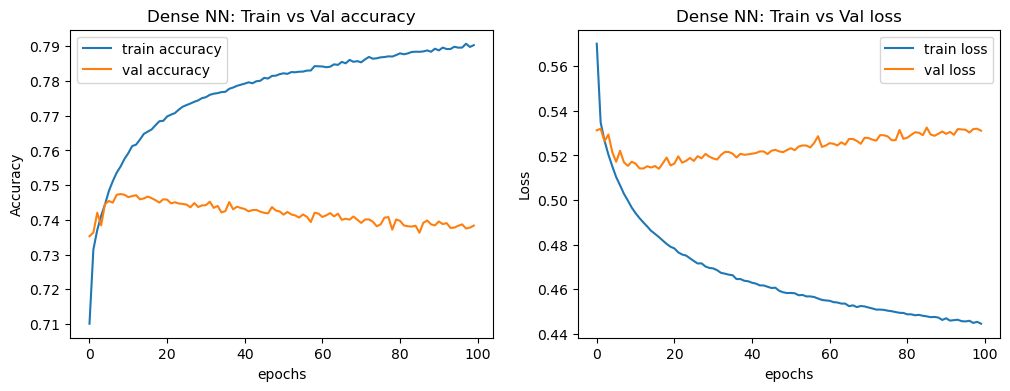

In [18]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model_metrics.history["accuracy"])
plt.plot(model_metrics.history["val_accuracy"])
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Dense NN: Train vs Val accuracy")
plt.legend(["train accuracy","val accuracy"])

plt.subplot(1, 2, 2)
plt.plot(model_metrics.history["loss"])
plt.plot(model_metrics.history["val_loss"])
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Dense NN: Train vs Val loss")
plt.legend(["train loss","val loss"])

plt.show()

#### confusion Matrix on val

In [27]:
import seaborn as sb

In [21]:
def plot_cf(Y_true, Y_pred):
    cf = confusion_matrix(Y_true, Y_pred)
    plt.figure(figsize=(8,8))
    sb.heatmap(cf, annot=True, fmt="d", cmap='Blues')
    return None

In [31]:
y_pred = nn_model.predict(x_val)

6503/6503 [==============================] - 6s 996us/step


In [25]:
y_pred = np.argmax(y_pred, axis=1)

Text(0.5, 1.0, 'Confusion Matrix for Fully connected Neural Network')

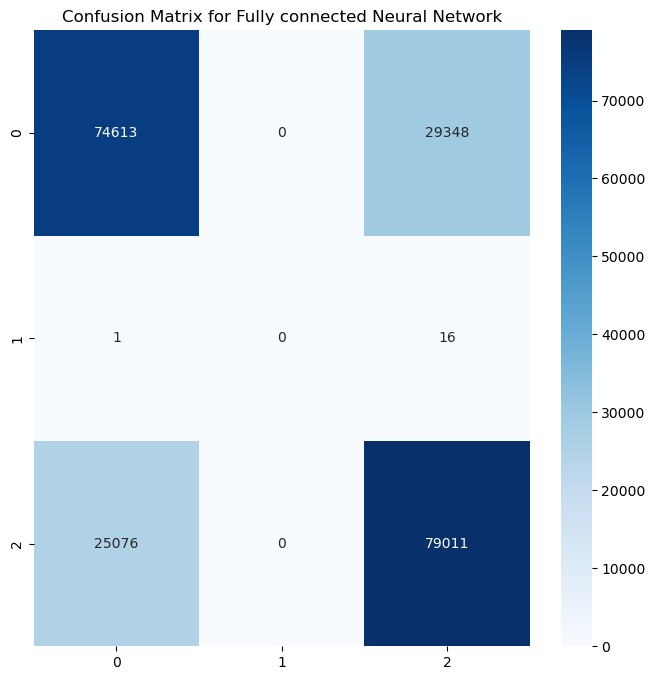

In [30]:
plot_cf(y_val, y_pred)
plt.title("Confusion Matrix for Fully connected Neural Network")

## Test

In [27]:
y_pred_test = nn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)

17506/17506 [==============================] - 18s 1ms/step


In [28]:
predictions_df = pd.DataFrame(y_pred_classes, columns=['target'])
predictions_df.index.name = 'id'

In [29]:
predictions_df

,target
id,
0,0
1,2
2,2
3,0
4,0
...,...
560170,0
560171,2
560172,0


In [30]:
path_output = os.path.abspath(os.path.join(os.getcwd(), os.pardir))+'\\Test_output\\test_results_NN.csv'

In [31]:
predictions_df.to_csv(path_output, index=True, index_label='id')

### References

- https://arxiv.org/pdf/1310.4546.pdf
- https://stackoverflow.com/questions/34721984/stopword-removing-when-using-the-word2vec
- https://radimrehurek.com/gensim/models/word2vec.html